In [1]:
#!/usr/bin/env python

import datetime as dt
import sqlite3
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def html_list(startdate, enddate):
    tsdate = startdate
    outlist = []
    while tsdate <= enddate:
        outlist.append(tsdate)
        date = dt.datetime.strptime(str(tsdate), '%y%m%d')
        date += dt.timedelta(days=7)
        tsdate = int(date.strftime('%y%m%d'))
    return outlist

def dataframe_creator(scraping_list):
    db = dict()
    for ind, timeval in enumerate(scraping_list):
        db[ind] = pd.read_csv(f'http://web.mta.info/developers/data/nyct/turnstile/turnstile_{timeval}.txt')
    return db

def local_database_creator(startdate=180623, weeks=14):
    conn = sqlite3.connect('ts_database')
    c = conn.cursor()
    datetime = (dt.datetime.strptime(str(startdate), '%y%m%d') + dt.timedelta(weeks=weeks-1))
    enddate = int(datetime.strftime('%y%m%d'))
    startdate = int((dt.datetime.strptime(str(startdate), '%y%m%d') - dt.timedelta(weeks = 1)).strftime('%y%m%d'))
    scraping_list = html_list(startdate, enddate)
    for val in scraping_list:
        date = str(val)
        c.execute(f"CREATE TABLE IF NOT EXISTS TS{date} ([STATION] TEXT)")
    conn.commit()
    db = dataframe_creator(scraping_list)
    for ind, val in enumerate(scraping_list):
        db[ind].to_sql(f'TS{val}', conn, if_exists = 'replace', index = False)
    print("Database Created")
    return scraping_list


tslist = local_database_creator()
tsdata = dict()

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:2779: UserWarning: The spaces in these column names will not be changed. In pandas versions < 0.14, spaces were converted to underscores.
  sql.to_sql(


Database Created


In [2]:
for val in tslist:
    tsdata[val] = pd.read_sql(f'''SELECT  "STATION", "DATE", "TIME", "ENTRIES", "EXITS",
                                    CASE WHEN "TIME" = "04:00:00" THEN "BENCH 1"
                                    WHEN "TIME" = "16:00:00" THEN "BENCH 2"
                                    WHEN "TIME" = "08:00:00" THEN "COUNT 1"
                                    WHEN "TIME" = "12:00:00" THEN "COUNT 2"
                                    ELSE "COUNT 3" END AS "TYPE"
                                    FROM "TS{str(val)}"
                                    WHERE "TIME" = "08:00:00" OR "TIME" = "12:00:00" OR "TIME" = "20:00:00" OR "TIME" = "04:00:00" OR "TIME" ="16:00:00"
                                    GROUP BY "DATE", "STATION", "TIME";''', sqlite3.connect('ts_database.db'))



print(tslist[0])
print(tsdata.keys())

180616
dict_keys([180616, 180623, 180630, 180707, 180714, 180721, 180728, 180804, 180811, 180818, 180825, 180901, 180908, 180915, 180922])


In [3]:
def daybreaker(tsdata):
    traffic = dict()
    for key in tsdata.keys():
        frame = tsdata[key]
        for date in sorted(set(frame["DATE"])):
            traffic[date] = {}
            for station in set(frame["STATION"]):
                bench_1 = [val for val in (frame[(frame["DATE"] == date) & (frame["TYPE"] == "BENCH 1") & (frame["STATION"] == station)][["ENTRIES","EXITS"]].sum(axis=1))]
                count_1 = [val for val in (frame[(frame["DATE"] == date) & (frame["TYPE"] == "COUNT 1") & (frame["STATION"] == station)][["ENTRIES","EXITS"]].sum(axis=1))]
                count_2 = [val for val in (frame[(frame["DATE"] == date) & (frame["TYPE"] == "COUNT 2") & (frame["STATION"] == station)][["ENTRIES","EXITS"]].sum(axis=1))]
                bench_2 = [val for val in (frame[(frame["DATE"] == date) & (frame["TYPE"] == "BENCH 2") & (frame["STATION"] == station)][["ENTRIES","EXITS"]].sum(axis=1))]
                count_3 = [val for val in (frame[(frame["DATE"] == date) & (frame["TYPE"] == "COUNT 3") & (frame["STATION"] == station)][["ENTRIES","EXITS"]].sum(axis=1))]
                if len(bench_1) != 1 or len(count_1) != 1 or len(count_2) != 1 or len(bench_2) != 1 or len(count_3) != 1:
                    continue
                else:
                    am = count_1[0]-bench_1[0]
                    mor = count_2[0]-count_1[0]
                    eve = count_3[0]-bench_2[0]
                    traffic[date].update({station : [am, mor, eve]})
    return traffic

traffic = daybreaker(tsdata)

In [42]:
morningframe = pd.DataFrame.from_dict(traffic)
flippedframe = morningframe.transpose()

In [43]:
def max_dict_creator(flippedframe):
    outdict = dict()
    for station in flippedframe.keys():
        outdict[station] = []
        outdict[station].append([val for val in flippedframe[station]])
    return outdict
max_dict = max_dict_creator(flippedframe)

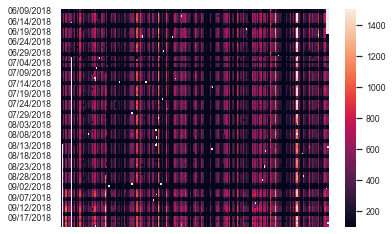

In [56]:
am_traffic = flippedframe.applymap(lambda x: x[0], na_action='ignore')
sns.set(font_scale = .8)
am_map = sns.heatmap(am_traffic, vmin = 100, vmax = 1500, xticklabels=False)
savemap = am_map.get_figure()
savemap.savefig('amtraffic.png', dpi=1000)

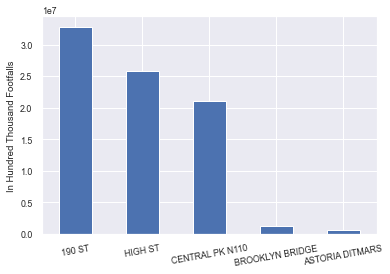

In [92]:
am_prime_stations = am_traffic.transpose()

am_series = pd.Series(am_prime_stations.mean(axis=1).sort_values(ascending=False))
am_series.head(5).plot.bar()
plt.xticks(rotation=10)
plt.ylabel("In Hundred Thousand Footfalls")
plt.savefig("Prime_AM.png")

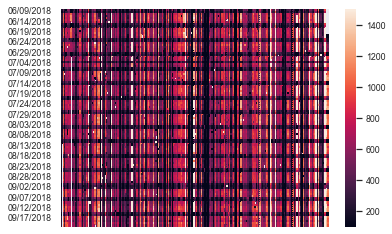

In [93]:
morn_traffic = flippedframe.applymap(lambda x: x[1], na_action='ignore')
morn_map = sns.heatmap(morn_traffic, vmin = 100, vmax = 1500, xticklabels=False)
savemap = morn_map.get_figure()
savemap.savefig('morntraffic.png', dpi=1000)

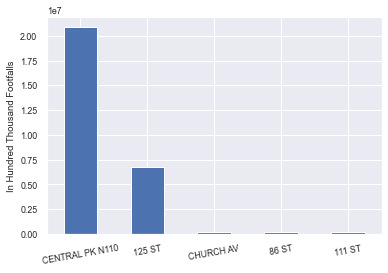

In [94]:
morn_prime_stations = morn_traffic.transpose()

morn_series = pd.Series(morn_prime_stations.mean(axis=1).sort_values(ascending=False))
morn_series.head(5).plot.bar()
plt.xticks(rotation=10)
plt.ylabel("In Hundred Thousand Footfalls")
plt.savefig("Prime_Morn.png")

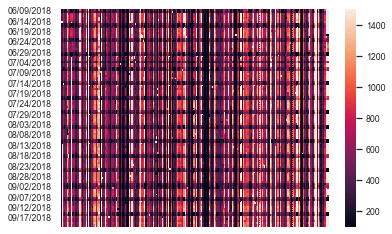

In [95]:
eve_traffic = flippedframe.applymap(lambda x: x[2], na_action='ignore')
eve_map = sns.heatmap(eve_traffic, vmin = 100, vmax = 1500, xticklabels=False)
savemap = eve_map.get_figure()
savemap.savefig('evetraffic.png', dpi=1000)

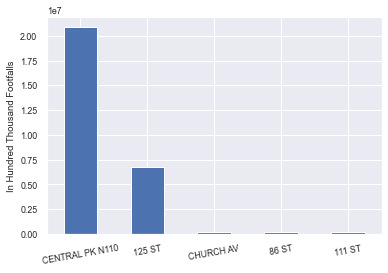

In [96]:
eve_prime_stations = eve_traffic.transpose()

eve_series = pd.Series(morn_prime_stations.mean(axis=1).sort_values(ascending=False))
eve_plot = eve_series.head(5).plot.bar()
plt.xticks(rotation=10)
plt.ylabel("In Hundred Thousand Footfalls")
plt.savefig("Prime_Eve.png")

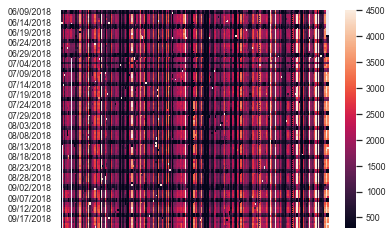

In [97]:
total_traffic = flippedframe.applymap(lambda x: sum(x) , na_action='ignore')
checkmap = sns.heatmap(total_traffic, vmin = 300, vmax = 4500, xticklabels=False)
savemap = checkmap.get_figure()
savemap.savefig('totaltraffic.png', dpi=1000)

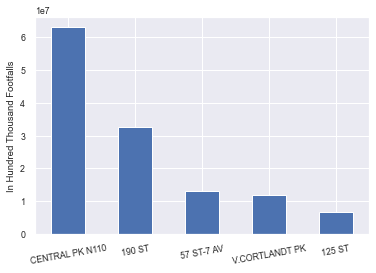

In [98]:
prime_total = total_traffic.transpose()

total_series = pd.Series(prime_total.mean(axis=1).sort_values(ascending=False))
total_plot = total_series.head(5).plot.bar()
plt.xticks(rotation=10)
plt.ylabel("In Hundred Thousand Footfalls")
plt.savefig("Prime_Total.png")

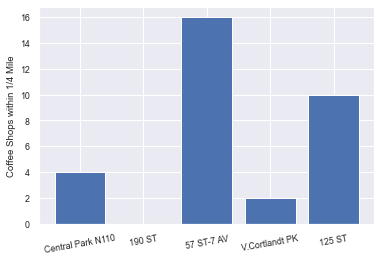

In [103]:
prime_station_list = ["Central Park N110", "190 ST", "57 ST-7 AV", "V.Cortlandt PK", "125 ST"]
coffee_shops = [4, 0, 16, 2, 10]
saturationplot = plt.bar(prime_station_list, coffee_shops)
plt.xticks(rotation=10)
plt.ylabel("Coffee Shops within 1/4 Mile")
plt.savefig("Coffee Saturation.png")
